**Requirements**
- You need to have the `cognite-sdk` package installed
- The environment variables `COGNITE_API_KEY` and `COGNITE_CLIENT_NAME` should be set

**IMPORTANT:** You have to run the python file "generate_comp_data.py" to create the time series for this tutorial

In [1]:
%matplotlib inline
import time
import requests

from cognite.client.experimental import CogniteClient
from cognite.model_hosting.data_spec import *
from cognite.model_hosting.data_fetcher import DataFetcher

client = CogniteClient()
mlh = client.model_hosting

# Deploy model


In this tutorial we will run a very simple scheduled model to demonstrate how to inspect the schedule logs for errors and how to set up notifications using webhooks. The specifics on how to make a source package, model and schedule are covered in depth in the other examples in the examples/model_hosting folder. However basic explanations will be written here.

Our model will look at the difference between two time series representing inlet pressure and outlet pressure of a compressor. We will calculate the CPR(Compressor Pressure Ration) of the compressor.

To ensure our model fails, we will make our model return the results using an incorrect format. The source package for this function can be found in the cpr folder. Later we will use the correct model, which can be found in the cprfix folder.

## 1. Create the model

First we will create a model container to where we will deploy our model versions.

In [2]:
model_name = "cpr-function"
mlh.models.create_model(
    name=model_name,
    input_fields=[{"name": "x1", "type": "TIME_SERIES"}, 
                  {"name": "x2", "type": "TIME_SERIES"}],
    output_fields=[{"name": "y", "type": "TIME_SERIES"}],
)

## 2. Create the source package

Then we upload our source package to the hosting environment

In [3]:
source_package_id = mlh.source_packages.build_and_upload_source_package(
    name="cpr", 
    runtime_version="0.1", 
    package_directory="cpr"
).id
source_package_id

5621544218520938

## 3. Deploy model

Then we deploy our function as a model version

In [4]:
version_name = "broken"
mlh.versions.deploy_model_version(
    model_name=model_name,
    version_name=version_name,
    source_package_id=source_package_id,
)

Before we proceed we need to ensure the model is deployed. This is done when the status is set to ready:

In [6]:
while mlh.versions.get_model_version(model_name, version_name).status == 'DEPLOYING':
    print(mlh.versions.get_model_version(model_name, version_name).status)
    time.sleep(10)
mlh.versions.get_model_version(model_name, version_name).status

DEPLOYING
DEPLOYING
DEPLOYING
DEPLOYING
DEPLOYING


'READY'

## 4. Set up schedule

Now we can create a schedule spec to define which data we will pass to our function and how the input data will be processed.

In [7]:
# NOTE: USE YOUR OWN TIME SERIES' HERE
INLET_TS = 1158466314740443 # Fill in your own time series ID
OUTLET_TS = 6792212704904482 # Fill in your own time series ID
CPR_TS = 4250884548062075  # Fill in your own time series ID

schedule_data_spec = ScheduleDataSpec(
    input=ScheduleInputSpec(
        time_series={
            "x1": ScheduleInputTimeSeriesSpec(
                id=INLET_TS, 
                aggregate="average", 
                granularity="10s"
            ),
            "x2": ScheduleInputTimeSeriesSpec(
                id=OUTLET_TS, 
                aggregate="average", 
                granularity="10s")
        }
    ),
    output=ScheduleOutputSpec(
        time_series={
            "y": ScheduleOutputTimeSeriesSpec(
                id=CPR_TS
            )
        }
    ),
    start="now",
    stride="1m",
    window_size="1m",
    slack="5m",
)

Now we can start running the schedule

In [9]:
schedule_name = "schedule-troubleshooting-tutorial"
mlh.schedules.create_schedule(
    model_name=model_name,
    schedule_name=schedule_name,
    schedule_data_spec=schedule_data_spec,
    description="CPR of 1stgcomp at Valhall"
)

The CPR time series is now being updated every minute.

# Troubleshoot

## Retrive and inspect schedule logs:

Now let's inspect the schedule logs to see how it's going. 

In [11]:
while len(mlh.schedules.get_log(model_name, schedule_name).dump()['failed'])<2:
    time.sleep(5)
mlh.schedules.get_log(model_name, schedule_name).dump()['failed'][0:3]

[{
     "timestamp": "2019-11-07 16:07:27",
     "scheduled_execution_time": "2019-11-07 16:06:50",
     "message": "Uncaught exception in the user code:\nTraceback (most recent call last):\n  File \"/tmp/custom_lib/ml_engine_base/base.py\", line 72, in _do_predict\n    return self._predict(instance=instance, **args)\n  File \"/tmp/custom_lib/cpr/model.py\", line 15, in predict\n    return to_output(df.size)\n  File \"/tmp/custom_lib/cognite/model_hosting/schedules/schedules.py\", line 42, in to_output\n    raise TypeError(\"dataframe should be a pandas DataFrame or list of pandas DataFrames\")\nTypeError: dataframe should be a pandas DataFrame or list of pandas DataFrames\n\nRemaining retries: 3"
 }, {
     "timestamp": "2019-11-07 16:07:28",
     "scheduled_execution_time": "2019-11-07 16:06:50",
     "message": "Uncaught exception in the user code:\nTraceback (most recent call last):\n  File \"/tmp/custom_lib/ml_engine_base/base.py\", line 72, in _do_predict\n    return self._predic

As we see the schedule is failing. Now you would change the predict funtion in the CPR module. However to keep this tutorial usable without changing the functions we create a new source package from the folder "cprfix".

In [12]:
source_package_id_fixed = mlh.source_packages.build_and_upload_source_package(
    name="cpr-fix", 
    runtime_version="0.1", 
    package_directory="cprfix"
).id

In [15]:
version_name_fixed = "cpr-function-fixed"
mlh.versions.deploy_model_version(
    model_name=model_name,
    version_name=version_name_fixed,
    source_package_id=source_package_id_fixed,
)

In [16]:
while mlh.versions.get_model_version(model_name, version_name_fixed).status == 'DEPLOYING':
    print(mlh.versions.get_model_version(model_name, version_name_fixed).status)
    time.sleep(10)
mlh.versions.get_model_version(model_name, version_name_fixed).status

DEPLOYING
DEPLOYING
DEPLOYING
DEPLOYING


'READY'

We now need to update the model to use the new source package

In [18]:
mlh.models.update_model(name=model_name, active_version_name=version_name_fixed)

,value
name,cpr-function
description,
createdTime,1573142552379
isDeprecated,False
activeVersionName,cpr-function-fixed
inputFields,"[{'type': 'TIME_SERIES', 'description': '', 'n..."
outputFields,"[{'type': 'TIME_SERIES', 'description': '', 'n..."


The schedule will now automatically use the new source package. We can ensure this is working by inspecting the latest schedule log. You can now see that there are new entries to the completed section. 

In [19]:
while len(mlh.schedules.get_log(model_name, schedule_name).dump()['completed'])<3:
    time.sleep(5)
mlh.schedules.get_log(model_name, schedule_name).dump()['completed'][0:3]

[{
     "timestamp": "2019-11-07 16:12:02",
     "scheduled_execution_time": "2019-11-07 16:07:50",
     "message": "Succesfully completed scheduled prediction"
 }, {
     "timestamp": "2019-11-07 16:13:02",
     "scheduled_execution_time": "2019-11-07 16:08:50",
     "message": "Succesfully completed scheduled prediction"
 }, {
     "timestamp": "2019-11-07 16:14:03",
     "scheduled_execution_time": "2019-11-07 16:09:50",
     "message": "Succesfully completed scheduled prediction"
 }]

We now see that the schedule is running without problems. We can now plot the compressor pressure ratio.

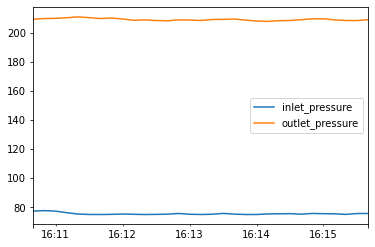

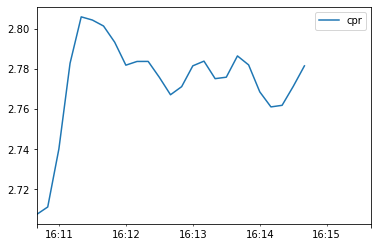

In [20]:
ds = DataSpec(
    time_series={
        "inlet_pressure": TimeSeriesSpec(
            id=INLET_TS, 
            aggregate="average", 
            granularity="10s", 
            start="5m-ago", 
            end="now"
        ),
        "outlet_pressure": TimeSeriesSpec(
            id=OUTLET_TS, 
            aggregate="average", 
            granularity="10s", 
            start="5m-ago", 
            end="now"
        ),
        "cpr": TimeSeriesSpec(
            id=CPR_TS, 
            aggregate="average", 
            granularity="10s", 
            start="5m-ago", 
            end="now"
        )
})

df = DataFetcher(ds).time_series.fetch_dataframe(["inlet_pressure", "outlet_pressure", "cpr"])
df.plot(y=['inlet_pressure','outlet_pressure'])
df.plot(y='cpr')

## Update model with webhook to recieve notifications for future failures: 

Since we already have created the schedule we give the schedule the webhook URL by updating it. Using webhooks we can get notified through the channel we desire(ex. email or Slack). 

In this case we have generated our webhook using Zapier. Documentation and examples on using Zapier are listed below.
- Direct message on slack: https://zapier.com/apps/slack/integrations/webhook/8904/get-slack-direct-messages-for-new-webhooks
- Emails through gmail: https://zapier.com/apps/gmail/integrations/webhook/1755/send-an-email-from-gmail-when-a-webhook-is-received
- Emails through outlook: https://zapier.com/apps/microsoft-outlook/integrations/webhook/54203/transmit-emails-in-microsoft-outlook-with-new-received-webhooks

Or see all the other integrations here: https://zapier.com/apps


To be able to customize the notification sent to us through Zapier without waiting for the schedule to fail you can use this manually sent request to trigger your hook. This will give you the fields of the error message.

In [21]:
webhook = 'https://hooks.zapier.com/hooks/catch/6030178/o4t74eu/' #Insert your personal webhook here

In [22]:
requests.post(webhook, json={'scheduleName':'Name of schedule',
                             'modelName': 'Model name', 
                             'timestamp': 'Time and date of log entry',
                             'scheduledExecutionTime': 'Time and date of prediction to schedule',
                             'message': 'The log message',
                            })

<Response [200]>

Since we already have created the schedule we give the schedule the webhook URL by updating it

In [23]:
mlh.models.update_model(name=model_name, webhook_url= webhook)

,value
name,cpr-function
description,
createdTime,1573142552379
isDeprecated,False
activeVersionName,cpr-function-fixed
inputFields,"[{'name': 'x1', 'description': '', 'type': 'TI..."
outputFields,"[{'name': 'y', 'description': '', 'type': 'TIM..."
webhookUrl,https://hooks.zapier.com/hooks/catch/6030178/o...


After fixing our model, we can now take a look at the output:

## Remember to clean up after yourself by deleting your model

In [25]:
mlh.models.delete_model(model_name)
mlh.source_packages.delete_source_package(source_package_id)
mlh.source_packages.delete_source_package(source_package_id_fixed)